In [1]:
from readers import *
from datalib import *
from filters import *
import config.config_jump_detection as config
import matplotlib.pyplot as plt
import time as t
%matplotlib notebook

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
expected_jumps = 3
expected_impacts = 2
window_lengths = range(3,41)
best_scores_amount = 5

In [3]:
start_time = t.time()
print("Reading demonstration data")

force_ext = []

for i in range(len(config.demos)):
    demo = config.demos[i]
    print(f'Reading demonstration file {demo}')

    force_ext.append(DataSet())

    # Read data
    franka_reader = FrankaStateReader(demo)
    while not franka_reader.end():
        dp = franka_reader.next_datapoint()
        time = dp.time
        franka_state = dp.value

        force_ext[i].append(DataPoint(time, franka_state.force_external_magnitude))

    # Align time
    force_ext[i].align_time()

print("--- %s seconds ---" % (t.time() - start_time))
print("Done")

Reading demonstration data
Reading demonstration file data/demo1.bag
Reading demonstration file data/demo2.bag
Reading demonstration file data/demo3.bag
Reading demonstration file data/demo4.bag
Reading demonstration file data/demo5.bag
Reading demonstration file data/demo8.bag
Reading demonstration file data/demo10.bag
Reading demonstration file data/demo11.bag
Reading demonstration file data/demo12.bag
Reading demonstration file data/demo13.bag
Reading demonstration file data/demo14.bag
Reading demonstration file data/demo15.bag
Reading demonstration file data/demo18.bag
Reading demonstration file data/demo19.bag
Reading demonstration file data/demo21.bag
--- 45.06866478919983 seconds ---
Done


In [28]:
def calc_proposed_bound(demo_local_maxima, expected_jumps_=None):
    if expected_jumps_ is None:
        expected_jumps_ = expected_jumps
    local_maxima_copy = demo_local_maxima.copy()
    local_maxima_copy.sort(reverse=True)
    return local_maxima_copy[expected_jumps_]

def propose_bound(proposed_bounds):
    return max(proposed_bounds)

def calc_score(detected_jumps, expected_jumps_=None):
    if expected_jumps_ is None:
        expected_jumps_ = expected_jumps
    return (expected_jumps_ - detected_jumps)**2

In [29]:
start_time = t.time()
print("Analyzing different window lengths")

scores = []
all_proposed_bounds = []

for window_length in window_lengths:

    jump_detector = config.jump_detector.copy()
    jump_detector.max_window_length = window_length
    jump_detector.bounder = NoneBounder()

    # Initialize results
    predictions = []
    all_local_maxima = []
    proposed_bounds = []

    for i in range(len(config.demos)):

        predictions.append(DataSet())

#         print(f'Detecting jumps of demonstration file {config.demos[i]}')

        # Detect jumps
        jump_detector.reset()
        for j in range(len(force_ext[i])):
            jump_detected, info = jump_detector.update(force_ext[i][j])
            predictions[i].append(info[0])

        # Output the data
        pred_diff = (force_ext[i] - predictions[i]).value
        local_maxima = []
        for j in range(len(pred_diff) - 2):
            k = j + 1
            if pred_diff[k] is None:
                continue
            if (pred_diff[k-1] is None or pred_diff[k] > pred_diff[k-1]) and (pred_diff[k+1] is None or pred_diff[k] > pred_diff[k+1]):
                local_maxima.append(pred_diff[k])
        all_local_maxima.append(local_maxima)
        proposed_bounds.append(calc_proposed_bound(local_maxima, expected_impacts+1))

    # Calculate score
    score = 0
    proposed_bound = propose_bound(proposed_bounds)
    jump_detector.bounder = config.jump_detector.bounder.copy()
    jump_detector.bounder.set_bound(proposed_bound)
    for i in range(len(config.demos)):

        detected_jumps = 0

        # Detect jumps
        jump_detector.reset()
        for j in range(len(force_ext[i])):
            jump_detected, info = jump_detector.update(force_ext[i][j])
            if info[4]:
                detected_jumps += 1

        score += calc_score(detected_jumps)

    scores.append(score)
    all_proposed_bounds.append(proposed_bound)

    print(f"The proposed bounds per demo for window_length {window_length} are {proposed_bounds} with a proposed_bound of {proposed_bound}")
    print(f"Score for window_length {window_length} is {score}")

print("--- %s seconds ---" % (t.time() - start_time))
print("Done")

Analyzing different window lengths


KeyboardInterrupt: 

In [26]:
start_time = t.time()
print("Calculating results")

all_best_indices = [i for i, value in sorted(enumerate(scores), key=lambda x:x[1])]
best_indices = all_best_indices[0:best_scores_amount]
index = best_scores_amount
while index < len(scores) and scores[all_best_indices[index]] == scores[all_best_indices[best_scores_amount-1]]:
    best_indices.append(all_best_indices[index])
    index += 1
best_scores = [scores[i] for i in best_indices]
best_window_lengths = [window_lengths[i] for i in best_indices]
best_bounds = [all_proposed_bounds[i] for i in best_indices]
print(f'The proposed window lengths are {best_window_lengths} with bounds {best_bounds} with scores {best_scores}')

print("--- %s seconds ---" % (t.time() - start_time))
print("Done")

Calculating results
The proposed window lengths are [] with bounds [] with scores []
--- 0.0005679130554199219 seconds ---
Done


<IPython.core.display.Javascript object>


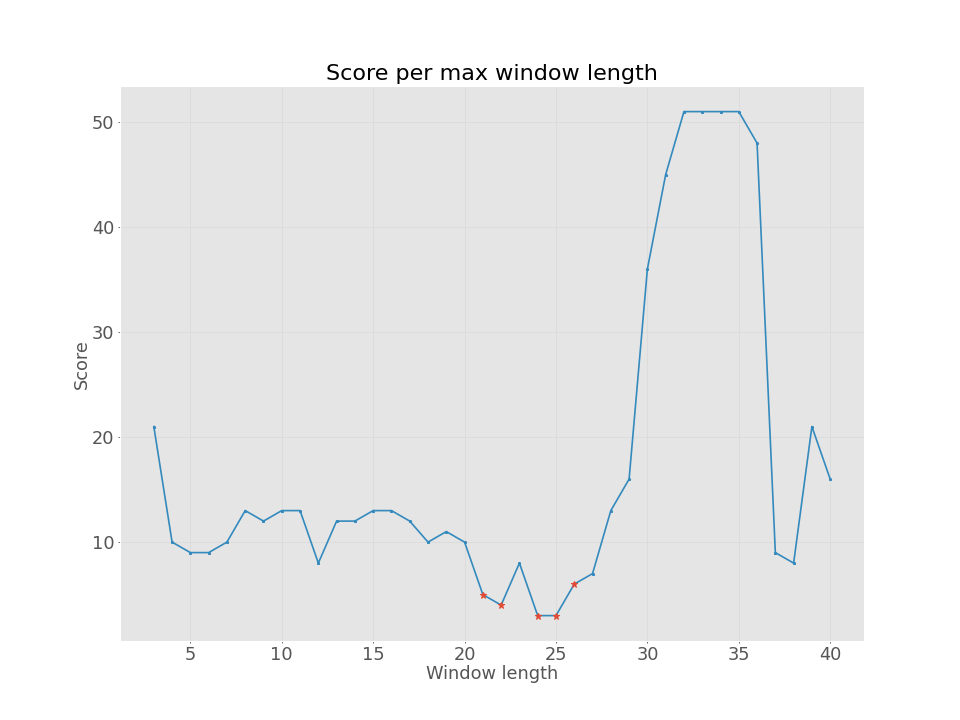

In [15]:
fig = plt.figure(figsize=config.figsize, dpi=config.dpi)
plt.rcParams['xtick.labelsize'] = config.fontsize2
plt.rcParams['ytick.labelsize'] = config.fontsize2
plt.plot(window_lengths, scores,'C1-*', linewidth=config.linewidth, markersize=config.markersize3)
plt.plot(best_window_lengths, best_scores,'C7*', linewidth=config.linewidth, markersize=config.markersize2)
plt.title('Score per max window length',fontsize=config.fontsize1)
plt.xlabel('Window length',fontsize=config.fontsize2)
plt.ylabel('Score',fontsize=config.fontsize2)
plt.show()

In [16]:
expected_impacts = 2

In [17]:
def calc_proposed_bound(prediction_differences):
    return min(prediction_differences)

def propose_bound(proposed_bounds):
    if len(proposed_bounds) > 0:
        return min(proposed_bounds)
    return None

def calc_score(detected_jumps, expected_jumps_=None):
    if expected_jumps_ is None:
        expected_jumps_ = expected_impacts
    return (expected_jumps_ - detected_jumps)**2

In [25]:
start_time = t.time()
print("Evaluating bounds and window_lengths")

all_scores = []
all_proposed_bounds = []

for w in range(len(best_window_lengths)):
    window_length = best_window_lengths[w]
    bound = best_bounds[w]
    
    print(f'Analyzing window_length {window_length} with bound {bound}')
    
    jump_indices = []
    predictions = []
    scores = []
    proposed_bounds = []
    
    for i in range(len(config.demos)):
        jump_indices.append([])
        predictions.append(DataSet())
        
        # Detect jumps
        jump_detector = config.jump_detector
        jump_detector.max_window_length = window_length
        jump_detector.bounder.set_bound(bound)
        jump_detector.reset()
        for j in range(len(force_ext[i])):
            jump_detected, info = jump_detector.update(force_ext[i][j])
            predictions[i].append(info[0])
            if jump_detected:
                jump_indices[i].append(j)
        
        # Calculate score
        score = calc_score(len(jump_indices[i]))
        scores.append(score)

        print(f"Score for demonstration file {config.demos[i]} is {score}")

        # Demo is valid
        if score == 0:
            jump_diffs = DataSet([force_ext[i][j] - predictions[i][j] for j in jump_indices[i]])
            proposed_bounds.append(calc_proposed_bound(jump_diffs.value))
    
    proposed_bound = propose_bound(proposed_bounds)
    all_scores.append(scores)
    all_proposed_bounds.append(proposed_bound)
    print(f"The proposed bounds are {proposed_bounds} with a proposed value of {proposed_bound}")
    
print("--- %s seconds ---" % (t.time() - start_time))
print("Done")

Evaluating bounds and window_lengths
Analyzing window_length 24 with bound 9.862803128625359
Score for demonstration file data/demo1.bag is 0
Score for demonstration file data/demo2.bag is 1
Score for demonstration file data/demo3.bag is 0
Score for demonstration file data/demo4.bag is 0
Score for demonstration file data/demo5.bag is 0
Score for demonstration file data/demo8.bag is 1
Score for demonstration file data/demo10.bag is 0
Score for demonstration file data/demo11.bag is 0
Score for demonstration file data/demo12.bag is 0
Score for demonstration file data/demo13.bag is 0
Score for demonstration file data/demo14.bag is 0
Score for demonstration file data/demo15.bag is 1
Score for demonstration file data/demo18.bag is 0
Score for demonstration file data/demo19.bag is 0
Score for demonstration file data/demo21.bag is 1
The proposed bounds are [11.219368021486275, 10.219085820796934, 10.433048745084765, 10.51013166001788, 9.941463387601697, 10.438173024081358, 9.910265664084811, 1

KeyboardInterrupt: 

In [24]:
start_time = t.time()
print("Calculating results")

total_scores = []
for scores in all_scores:
    total_scores.append(sum(scores))
    
print(f'The total scores for window_lengths {best_window_lengths} with bounds {best_bounds} are {total_scores}')

indices = [i for i, value in sorted(enumerate(total_scores), key=lambda x:x[1])]
best_indices = [indices[0]]
best_total_score = total_scores[indices[0]]
index = 1
while index < len(total_scores) and total_scores[indices[index]] == best_total_score:
    best_indices.append(indices[index])
    index += 1

best_total_scores = [total_scores[i] for i in best_indices]
best_total_window_lengths = [best_window_lengths[i] for i in best_indices]
best_total_bounds = [best_bounds[i] for i in best_indices]

indices = [i for i, value in sorted(enumerate(best_total_bounds), key=lambda x:x[1])]
best_total_window_length = best_total_window_lengths[indices[0]]
best_total_score = best_total_scores[indices[0]]
best_total_bound = best_total_bounds[indices[0]]

print(f'The proposed window length is {best_total_window_length} with bound {best_total_bound} with score {best_total_score}')

print("--- %s seconds ---" % (t.time() - start_time))
print("Done")

Calculating results
The total scores for window_lengths [24, 25] with bounds [9.862803128625359, 9.867738470940107] are [4, 4, 5, 6, 7]
The proposed window length is 24 with bound 9.862803128625359 with score 4
--- 0.0007379055023193359 seconds ---
Done
